In [153]:
!pip install tiktoken

In [154]:
import pandas as pd

In [155]:
medical_reports = pd.read_csv("reports.csv")

In [156]:
medical_reports.head()

,medical_specialty,report
0,Cardiovascular / Pulmonary,"2-D M-MODE: , ,1. Left atrial enlargement wit..."
1,Cardiovascular / Pulmonary,1. The left ventricular cavity size and wall ...
2,Cardiovascular / Pulmonary,"2-D ECHOCARDIOGRAM,Multiple views of the heart..."
3,Cardiovascular / Pulmonary,"DESCRIPTION:,1. Normal cardiac chambers size...."
4,Cardiovascular / Pulmonary,"2-D STUDY,1. Mild aortic stenosis, widely calc..."


In [157]:
medical_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


In [158]:
medical_reports.dropna(subset=['report'],inplace=True)
medical_reports.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2179 entries, 0 to 2178
Data columns (total 2 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   medical_specialty  2179 non-null   object
 1   report             2179 non-null   object
dtypes: object(2)
memory usage: 34.2+ KB


In [159]:
grouped_data = medical_reports.groupby('medical_specialty').sample(110,random_state=42)

In [160]:
grouped_data['medical_specialty'].value_counts()

medical_specialty
Cardiovascular / Pulmonary    110
Gastroenterology              110
Neurology                     110
Radiology                     110
Surgery                       110
Name: count, dtype: int64

In [161]:
grouped_data = medical_reports.groupby("medical_specialty").sample(110, random_state=42) # Sample 110 items from each class

val_test_data = grouped_data.groupby("medical_specialty").sample(10, random_state=42)  # sample 10 items from the above data
val = val_test_data.groupby("medical_specialty").head(5) # Take the first 5 of each class
test = val_test_data.groupby("medical_specialty").tail(5) # Take the last 5 of each class

train = grouped_data[~grouped_data.index.isin(val_test_data.index)] # Take the remaining ones for training

In [162]:
train = grouped_data[~grouped_data.index.isin(val_test_data.index)]

In [163]:
len(train)

500

In [164]:
train

,medical_specialty,report
2135,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSES:,1. Lumbar osteomyelit..."
1841,Cardiovascular / Pulmonary,"PREOPERATIVE DIAGNOSES:,1. Non-small-cell car..."
1823,Cardiovascular / Pulmonary,"PROCEDURE: , Urgent cardiac catheterization wi..."
2122,Cardiovascular / Pulmonary,"PROCEDURE:, Left Cardiac Catheterization, Lef..."
2047,Cardiovascular / Pulmonary,"EXAM: , Coronary artery CTA with calcium scori..."
...,...,...
700,Surgery,"HISTORY OF PRESENT ILLNESS:, Briefly, this is..."
74,Surgery,"PREOPERATIVE DIAGNOSIS: ,Thyroid goiter with ..."
470,Surgery,"PREOPERATIVE DIAGNOSIS:,1. Cholelithiasis.,2...."
880,Surgery,"PREOPERATIVE DIAGNOSIS: , Cataract, left eye.,..."


In [165]:
import tiktoken

In [166]:
def num_token_from_string(string):
    encoding = tiktoken.get_encoding('cl100k_base')
    num_tokens = len(encoding.encode(string))
    return num_tokens

In [167]:
# num_token_from_string("Hello world how are you regularizationsupersuper")

In [168]:
reports_lengths  =train['report'].apply(num_token_from_string)

In [169]:
reports_lengths.sum()

337394

In [170]:
price_model = 0.008

In [171]:
price_per_epoch = 337394 * 0.008/1000

In [172]:
price_per_epoch

2.699152

In [173]:
train['medical_specialty'].unique()

array(['Cardiovascular / Pulmonary', 'Gastroenterology', 'Neurology',
       'Radiology', 'Surgery'], dtype=object)

In [174]:
system_prompt ="given the medical description report, classify it into on of these categories: "+ \
    "Cardiovascular / Pulmonary, Gastroenterology, Neurology,Radiology, Surgery"

In [175]:
print(system_prompt)

given the medical description report, classify it into on of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology,Radiology, Surgery


In [176]:
sample_prompt = {"messages":[{'role':'system','content':system_prompt},
                             {'role':'user',"content":train['report'].iloc[0]},
                             {'role':'assistant','content':train['medical_specialty'].iloc[0]}]}

In [177]:
# print(sample_prompt)

In [178]:
def df_to_format(df):
    formatted_data = []

    for index,row in df.iterrows():
        entry = {"messages":[{'role':'system','content':system_prompt},
                             {'role':'user',"content":row['report']},
                             {'role':'assistant','content':row['medical_specialty']}]}
        formatted_data.append(entry)

    return formatted_data


In [179]:
data = df_to_format(train)

In [180]:
# data[10]

In [181]:
import json

with open('fine_tunning_data.jsonl','w') as f:
    for entry in data:
        f.write(json.dumps(entry))
        f.write("\n")


In [182]:
val_data = df_to_format(val)

In [183]:
import json
with open('fine_tuning_data_val.jsonl', 'w') as f:
    for entry in val_data:
        f.write(json.dumps(entry))
        f.write("\n")


In [184]:
import os
import openai

In [185]:
from openai import OpenAI

client = OpenAI(api_key='')

In [186]:
file_upload_response = client.files.create(file=open('fine_tunning_data.jsonl','rb'),purpose='fine-tune')

In [187]:
file_upload_response

FileObject(id='file-4fxhzBUVxCS1jtsETQyid7BF', bytes=1541622, created_at=1715486613, filename='fine_tunning_data.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [188]:
file_upload_response_val = client.files.create(file=open('fine_tuning_data_val.jsonl','rb'),purpose='fine-tune')

In [189]:
file_upload_response_val

FileObject(id='file-EG4OCJZtQDPF3BuWlbJoq4l4', bytes=101384, created_at=1715486614, filename='fine_tuning_data_val.jsonl', object='file', purpose='fine-tune', status='processed', status_details=None)

In [190]:
fine_tunning_response = client.fine_tuning.jobs.create(training_file=file_upload_response.id,model='gpt-3.5-turbo',
                                                       hyperparameters={'n_epochs':1},
                                                       validation_file=file_upload_response_val.id
                                                       )

In [203]:
fine_tunning_response

FineTuningJob(id='ftjob-LdhQePJqOo1rjGQOjpeFUvji', created_at=1715486616, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size='auto', learning_rate_multiplier='auto'), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-bF5sIsIpFOTi6Yk29wkHlvjy', result_files=[], seed=366653837, status='validating_files', trained_tokens=None, training_file='file-4fxhzBUVxCS1jtsETQyid7BF', validation_file='file-EG4OCJZtQDPF3BuWlbJoq4l4', estimated_finish=None, integrations=[], user_provided_suffix=None)

In [204]:
client.fine_tuning.jobs.list(limit=1)

SyncCursorPage[FineTuningJob](data=[FineTuningJob(id='ftjob-LdhQePJqOo1rjGQOjpeFUvji', created_at=1715486616, error=Error(code=None, message=None, param=None), fine_tuned_model=None, finished_at=None, hyperparameters=Hyperparameters(n_epochs=1, batch_size=1, learning_rate_multiplier=2), model='gpt-3.5-turbo-0125', object='fine_tuning.job', organization_id='org-bF5sIsIpFOTi6Yk29wkHlvjy', result_files=[], seed=366653837, status='cancelled', trained_tokens=None, training_file='file-4fxhzBUVxCS1jtsETQyid7BF', validation_file='file-EG4OCJZtQDPF3BuWlbJoq4l4', estimated_finish=None, integrations=[], user_provided_suffix=None)], object='list', has_more=True)

In [205]:
train_event = client.fine_tuning.jobs.list_events(fine_tuning_job_id='ftjob-NlpnHTlIM6Y2qAPJ1aq3rlQI',
                                                     limit=500)

In [215]:
train_event.data[0]

FineTuningJobEvent(id='ftevent-qlDlGtiItouBML80jWajQ6cg', created_at=1715486110, level='info', message='The job has successfully completed', object='fine_tuning.job.event', data={}, type='message')

In [223]:
train_loss = []
val_loss = []

for item in train_event.data:
    # train_data = data
    if 'train_loss' in item.data and 'valid_loss' in item.data:
        train_loss.insert(0, item.data['train_loss'])
        val_loss.insert(0, item.data['valid_loss'])

In [225]:
train_loss

[1.497790813446045,
 0.00011420249938964844,
 4.6271514892578125,
 0.00035349527024663985,
 2.86102294921875e-06,
 3.295041561126709,
 0.00013780593872070312,
 0.00022864341735839844,
 0.0003452301025390625,
 1.271565793103946e-06,
 2.0343053340911865,
 0.0008063316345214844,
 3.1240580081939697,
 7.629394644936838e-07,
 7.629394644936838e-07,
 0.004899263381958008,
 4.76837158203125e-07,
 6.35782896551973e-07,
 6.35782896551973e-07,
 9.5367431640625e-07,
 3.506896495819092,
 4.00543212890625e-05,
 6.35782896551973e-07,
 6.35782896551973e-07,
 5.75845193862915,
 7.629394644936838e-07,
 4.37109899520874,
 7.629394644936838e-07,
 1.430511474609375e-06,
 9.5367431640625e-06,
 9.5367431640625e-07,
 6.35782896551973e-07,
 0.16057968139648438,
 4.76837158203125e-07,
 2.6668410301208496,
 1.1361653804779053,
 4.76837158203125e-07,
 2.384185791015625e-07,
 0.0013027191162109375,
 9.5367431640625e-07,
 3.081785202026367,
 3.178914482759865e-07,
 2.384185791015625e-07,
 7.629394644936838e-07,
 6

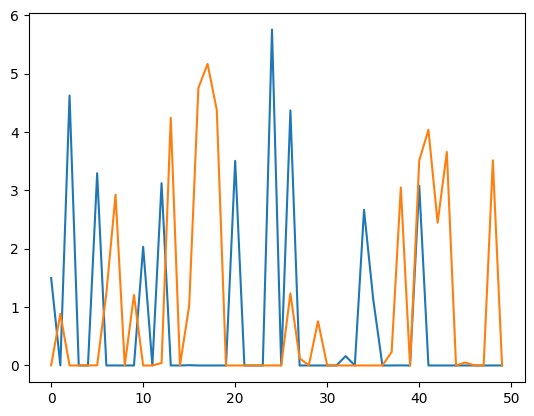

In [226]:
import matplotlib.pyplot as plt
plt.figure()
plt.plot(train_loss)
plt.plot(val_loss)

In [231]:
test_reports = test['report'].iloc[1]

In [236]:
completion = client.chat.completions.create(model='ft:gpt-3.5-turbo-0125:personal::9NuagHuq',
                                            messages=[
                                                {'role':'system','content':system_prompt},
                                                {
                                                    'role':'user','content':test_reports
                                                }
                                            ]
                                            )

In [233]:
completion.choices[0].message

ChatCompletionMessage(content='This medical description report falls under the category of Cardiovascular / Pulmonary.', role='assistant', function_call=None, tool_calls=None)

In [234]:
system_prompt

'given the medical description report, classify it into on of these categories: Cardiovascular / Pulmonary, Gastroenterology, Neurology,Radiology, Surgery'

In [239]:
completion.choices[0].message.content.strip()

'Cardiovascular / Pulmonary'

In [243]:
def classify_report(report,model):
    completion = client.chat.completions.create(model=model,
                                            messages=[
                                                {'role':'system','content':system_prompt},
                                                {
                                                    'role':'user','content':report
                                                }
                                            ]
                                            )
    return completion

In [244]:
predicted_classes   =[]
ground_truth_classes = []

for line in test.iterrows():
    report,specialty = line[1]['report'],line[1]['medical_specialty']
    ground_truth_classes.append(specialty.strip())
    prediction = classify_report(report,model='gpt-3.5-turbo')
    predicted_classes.append(prediction.choices[0].message.content.strip())

In [246]:
import numpy as np

(np.array(predicted_classes) == np.array(ground_truth_classes)).mean()

0.44

In [247]:
predicted_classes   =[]
ground_truth_classes = []

for line in test.iterrows():
    report,specialty = line[1]['report'],line[1]['medical_specialty']
    ground_truth_classes.append(specialty.strip())
    prediction = classify_report(report,model='ft:gpt-3.5-turbo-0125:personal::9NuagHuq')
    predicted_classes.append(prediction.choices[0].message.content.strip())

In [248]:
import numpy as np

(np.array(predicted_classes) == np.array(ground_truth_classes)).mean()

0.64